<a href="https://colab.research.google.com/github/Generative-AI-for-Analog-Chip-Design/cap-matrix-predictor/blob/main/InterconnectCapPredictorExercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Necessary Library

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pickle
import matplotlib.pyplot as plt
import numpy as np
import urllib.request

 # Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Input Data import and read-out

In this example, we are looking to estimate the capacitance matrix due to interconnects given the cross-layer profile of the layout.

For reference, there is in the open source domain toolchain for the layout that enables testing for interconnection layout: https://github.com/yuchsiao/caplet

An illustration of such interconnection is given as follows:  

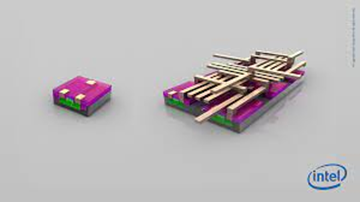


A dataset of such samples (the metalization profile and the corresponding capacitance matrix) was generated and is provided.
The following image illustrates a simplified connection profile with 3 nodes and a 3x3 capacitance matrix. Where c_n is the capacitante to subtrate of node n, and cc_n_m is the cross capacitance between nodes n and m.

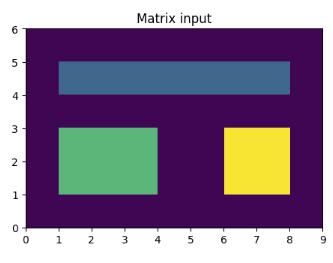


Capcitance Matrix :

             | c_1    cc_1_2   cc_1_3|
             |cc_2_1    c_2    cc_2_3|
             |cc_3_1  cc_3_2     c_3 |





The first step in this Notebook is to load it from a Python compressed file (pkl). Each data point is a dictionary containing the geometry description ['input_arr'] and the associated capacitance matrix ['cmat'] .

In [2]:
# Load data from the uploaded pickle file

data = pickle.load(urllib.request.urlopen('https://github.com/coustam/test/raw/main/caplet_test.pkl'))

Matrix for key file (Dictionary 1) is not a valid NumPy array.


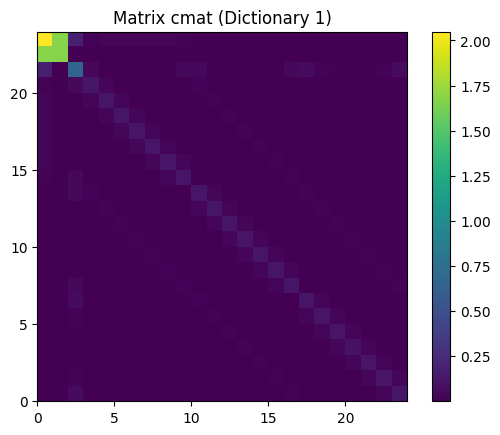

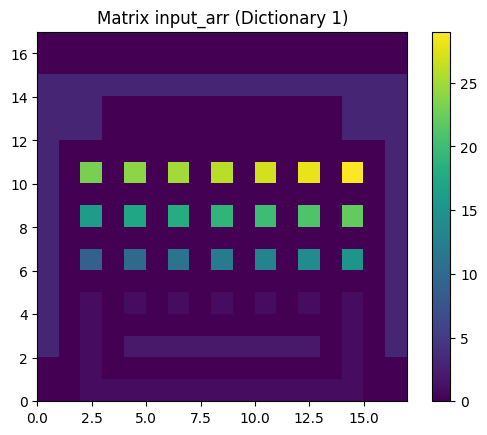

In [3]:
# Shows a data point
def visualize_matrix(data, index):
    """
    Visualize a matrix from the data at the given index.

    Parameters:
    data (list): List of dictionaries containing matrix data.
    index (int): Index of the dictionary to visualize.

    Returns:
    None
    """
    if isinstance(data, list) and data:
        if index < 0 or index >= len(data):
            print("Invalid index. Index should be within the range of the data list.")
            return

        dictionary = data[index]

        if isinstance(dictionary, dict):
            for key, matrix in dictionary.items():
                if isinstance(matrix, np.ndarray):
                    plt.figure()
                    plt.imshow(matrix, cmap='viridis', extent=[0, matrix.shape[1], 0, matrix.shape[0]])
                    plt.title(f'Matrix {key} (Dictionary {index+1})')
                    plt.colorbar()
                    plt.show()
                else:
                    print(f"Matrix for key {key} (Dictionary {index+1}) is not a valid NumPy array.")

visualize_matrix(data, 0)

Matrix for key file (Dictionary 1347) is not a valid NumPy array.


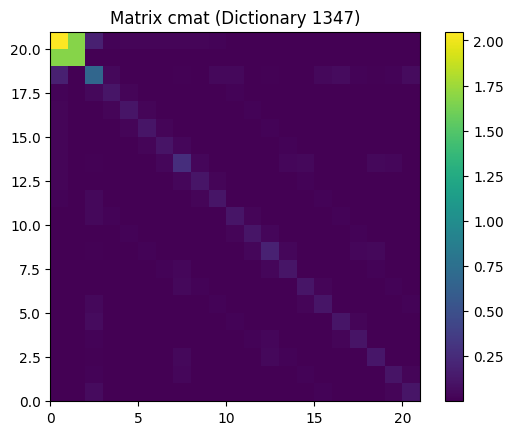

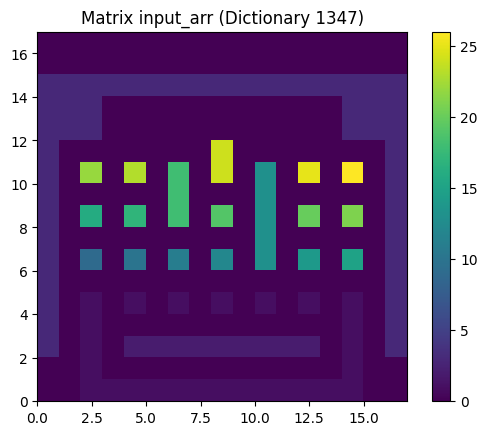

In [4]:
visualize_matrix(data, 1346)

At this point, we will prepare a model to learn the capacitance value as a function of the metalization patterns.

The following cells have a straightforward implementation that should speed up developments. There is no time limit, but we expect a maximum of a few hours to be needed.

As you proceed, please take note to address the following questions:

###Data Format and Structure:
    1. What is the raw data format (e.g., images, text, numerical data)?
    2. How is the data structured (e.g., files, databases, APIs)?

###Data Preprocessing:
    3. What preprocessing steps are needed for this specific type of data (e.g., normalization, scaling, encoding)?
    4. Are there missing values, and how should they be handled (e.g., imputation, removal, special handling)?

###Data Loading and Batching:
    5. How will the data be loaded into memory or accessed during training (e.g., batches, streaming, data loaders)?
    6. What is the appropriate batch size for efficient training?

###Data Augmentation:
    7. Do we need to apply data augmentation techniques to increase the diversity of the training set (e.g., rotation, flipping, zooming for images)?
    8. How can data augmentation help in improving model generalization?

###Data Splitting:
    9. How should the data be split into training, validation, and testing sets (e.g., random split, stratified split)?
    10. What is the ratio or percentage for each set?

###Data Loading Performance:
    11. How can we optimize data loading for better performance during training (e.g., parallel loading, prefetching)?

###Memory and Resource Considerations:
    12. Do we have enough memory to load the entire dataset, or do we need to use data streaming or mini-batching methods?

###Data Visualization:
    13. Can specific visualizations help understand the data? Which ones?

###Training and Loss
    14. What should be the loss?
    15. How should the model be trained?
    16. How to evaluate how good is the trained model?


## Follow this general steps:
1. Preprocess data
2. Create the dataset, split the data, and create the loader
3. Define the model
4. Define the loss
5. Train the model
6. Evaluate the performance of the model
7. Discuss the findings

In [5]:
#1. Pre processing



In [6]:
#2. Create the dataset and split the data.
# Bellow is as place holder for a basic torch Dataset, feel free to change.

class Pattern_dataset(Dataset):
    def __init__(self, aPattern_dataset):
        """
        Constructor for the Pattern_dataset class.

        Parameters:
        aPattern_dataset (list): List containing pattern dataset.

        Attributes:
        data (list): Pattern dataset.

        Initializes the Pattern_dataset instance with the provided pattern dataset.
        """
        super().__init__()  # Call the constructor of the inherited class
        self.data = aPattern_dataset

    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
        int: Length of the dataset.

        Overrides the __len__ method from the inherited class to return the length of the dataset.
        """
        return len(self.data)

    def __getitem__(self, index):
        """
        Get a specific item from the dataset.

        Parameters:
        index (int): Index to retrieve the item from.

        Returns:
        torch.Tensor, torch.Tensor: Input and output tensors.

        Overrides the __getitem__ method from the inherited class to retrieve the input and output tensors
        corresponding to the given index.
        """

        # Input for regression and output of regression
        p, c = torch.tensor(self.data[index]['input_arr']).to(torch.float).to(device), \
               torch.tensor(self.data[index]['cmat']).to(torch.float).to(device)

        ph, pw = p.shape
        ch, cw = c.shape

        # Pad the input and output tensors to match specified dimensions
        padded_p = torch.nn.functional.pad(p, (0, 30 - pw, 0, 30 - ph)).unsqueeze(0)
        padded_c = torch.nn.functional.pad(c, (0, 20 - cw, 0, 20 - ch))

        return padded_p, padded_c

# Create an instance of the Pattern_dataset class with the provided data
pattern_data = Pattern_dataset(data)

# Get the length of the dataset
dataset_length = len(pattern_data)

# Get an example item from the dataset and print its shape
x, y = pattern_data[1]
print("Shape of input tensor (x):", x.shape)
print("Shape of output tensor (y):", y.shape)

# Create a DataLoader for the pattern dataset
# Define the ratio for train and inference split (e.g., 60% train, 40% inference)
train_ratio = 0.6
inference_ratio = 1.0 - train_ratio

# Calculate the number of samples for each subset
train_size = int(train_ratio * len(pattern_data))
inference_size = len(pattern_data) - train_size

# Split the dataset
train_dataset, inference_dataset = random_split(pattern_data, [train_size, inference_size])

# Create DataLoaders for training and inference
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
inference_loader = DataLoader(dataset=inference_dataset, batch_size=64, shuffle=False)



Shape of input tensor (x): torch.Size([1, 30, 30])
Shape of output tensor (y): torch.Size([20, 20])


In [7]:
#3. Define the model

class CapModel(nn.Module):
    def __init__(self, num_classes=10):
        """
        Constructor for the model class.

        Parameters:
        num_classes (int): Number of output classes.

        Initializes the model with specified number of output classes.
        """
        super(CapModel, self).__init__()

        # Layers
        # First convolutional layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # 1 input channel, 16 output channels, 3x3 kernel
            nn.BatchNorm2d(16),  # Batch normalization
            nn.ReLU(),  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2))  # Max pooling

        # Second convolutional layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # 16 input channels, 32 output channels, 3x3 kernel
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(),  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2))  # Max pooling

        # Fully connected layer
        self.fc = nn.Linear(1568, 20*20)  # Fully connected layer with output size 20*20
    def forward(self, x):
        """
        Forward pass of the ConvNet.

        Parameters:
        x (torch.Tensor): Input tensor.

        Returns:
        torch.Tensor: Output tensor.

        Defines the forward pass for the ConvNet.
        """
        # dummy pass
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)  # Flatten the output
        out = self.fc(out).reshape(-1, 20, 20)  # Fully connected layer and reshape
        return out

# Create an instance of the ConvNet model with 2 output classes
model = CapModel(2)

# Move the model to the specified device (e.g., GPU)
model = model.to(torch.device(device))

# Print the model architecture
print("CapModel Model:")
print(model)




CapModel Model:
CapModel(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=400, bias=True)
)


In [8]:
# 4. Define the loss

# is this loss sensible? How to improve it?

def SMAPE(a, b):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE) between tensors a and b.

    Parameters:
    a (torch.Tensor): Ground truth tensor.
    b (torch.Tensor): Predicted tensor.

    Returns:
    torch.Tensor: SMAPE loss.
    """
    return 2 * torch.mean(torch.abs(a - b) / (torch.abs(a) + torch.abs(b) + 1e-3))

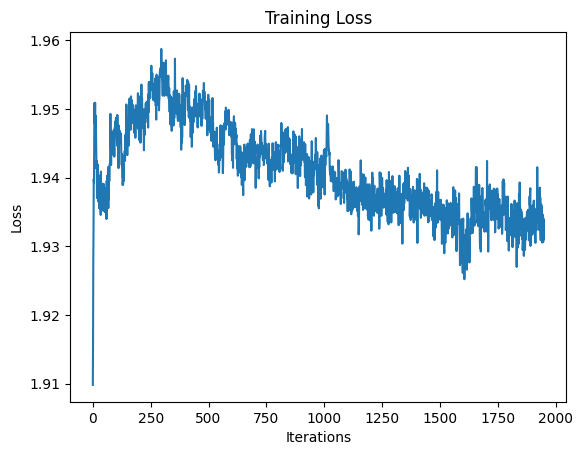

In [9]:
# 5. Train the model - just a placeholder, edit as needed

# Define the optimizer for model parameters using Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

total_step = len(train_loader)  # Total number of batches in the dataset
losses = []  # List to store the losses during training

for epoch in range(50):
    for i, (pattern, caps) in enumerate(train_loader):

        pattern = pattern.to(device)  # Move pattern to the selected device (CPU/GPU)
        caps = caps.to(device)  # Move caps to the selected device (CPU/GPU)

        # Forward pass
        outputs = model(pattern)

        # Calculate SMAPE loss
        loss = SMAPE(caps, outputs)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())  # Store the loss for this batch

# Specify the file path to save the model
model_path = 'Capregression.pth'

# Save the model's state dictionary and other important components
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'losses': losses
}, model_path)

# Plot losses
epochs = range(50 * total_step)
plt.plot(epochs, losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

SMAPE on inference set: 1.9325448274612427


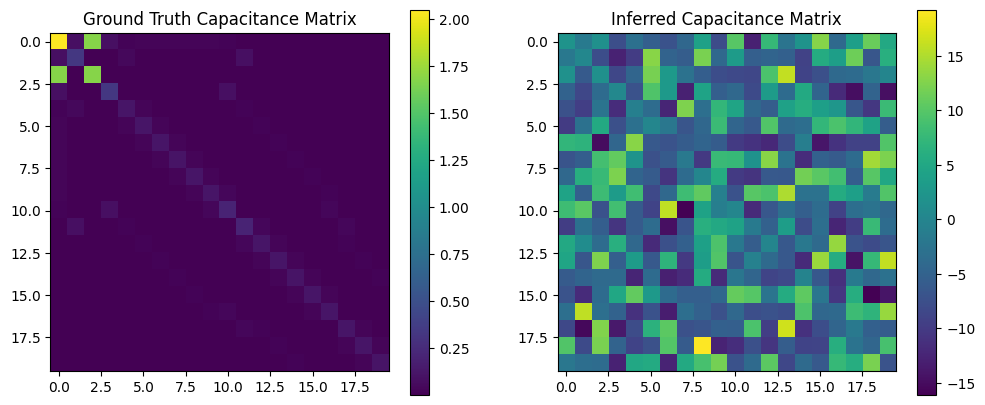

In [10]:
#6. Evaluate the performance of the model
# Load the model
loaded_model = CapModel(2)  # Assuming ConvNet is your model class
loaded_model = loaded_model.to(device)  # Move the model to the selected device (CPU/GPU)

# Load the saved model state dictionary
checkpoint = torch.load(model_path)
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Ensure the model is in evaluation mode for inference
loaded_model.eval()

# Initialize a list to store predicted values and ground truth
predictions = []
ground_truth = []

# Run inference and calculate error
with torch.no_grad():
    for i, (pattern, caps) in enumerate(inference_loader):
        pattern = pattern.to(device)
        caps = caps.to(device)

        # Forward pass
        outputs = model(pattern)

        # Append predictions and ground truth
        predictions.append(outputs.cpu().numpy())  # Convert to numpy array and move to CPU
        ground_truth.append(caps.cpu().numpy())  # Convert to numpy array and move to CPU

# Concatenate the predictions and ground truth
predictions = np.concatenate(predictions)
ground_truth = np.concatenate(ground_truth)

# Calculate the SMAPE error
inference_smape = SMAPE(torch.tensor(ground_truth), torch.tensor(predictions))

print("SMAPE on inference set:", inference_smape.item())

# Initialize variables to store errors and corresponding samples
errors = []
sample_indices = []

# Set the model to evaluation mode
model.eval()

# Run inference and calculate error for each sample
with torch.no_grad():
    for i, (pattern, caps) in enumerate(inference_loader):
        pattern = pattern.to(device)
        caps = caps.to(device)

        # Forward pass
        outputs = model(pattern)

        # Calculate SMAPE error for this sample
        error = SMAPE(caps, outputs).item()

        # Store the error and sample index
        errors.append(error)
        sample_indices.append(i)

# Find the index of the sample with the highest error
worst_sample_index = sample_indices[np.argmax(errors)]

# Get the pattern and ground truth for the worst sample
worst_pattern, worst_caps = inference_dataset[worst_sample_index]

# Forward pass for the worst sample
worst_outputs = model(worst_pattern.unsqueeze(0).to(device))
worst_outputs = worst_outputs.detach().cpu().numpy()

# Plot the capacitance matrix for the worst sample
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(worst_caps.squeeze(), cmap='viridis')
plt.title('Ground Truth Capacitance Matrix')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(worst_outputs.squeeze(), cmap='viridis')
plt.title('Inferred Capacitance Matrix')
plt.colorbar()

plt.show()

##7. Discuss the findings

Please note the implemented model does not need to be perfect, just good enough! Feel free to discuss ideas to improve it.
